In [159]:
import pickle
import pandas as pd

# 데이터 읽어오기
df = pd.read_pickle('path_df.pkl')
exploit=df
exploit

EID   PATH_NUM                                       SYSCALL_PATH
0     10613  exit_code                                           [102, 1]
1     10613  exit_code                            [102, 1, 12, 12, 1, 59]
2     10613  exit_code                                           [102, 1]
3     10613  exit_code                            [102, 1, 12, 12, 1, 59]
4     10613       main            [102, 104, 1, 117, 119, 9, 9, 9, 9, 11]
...     ...        ...                                                ...
4076   9545       main                                  [102, 104, 9, 41]
4077   9545       main                  [102, 104, 9, 41, 87, 77, 40, 59]
4078   9545       main                                      [102, 104, 9]
4079   9575       main  [41, inet_addr, htons, 9, 46, 46, 3, 13, 13, 1...
4080   9575       main  [41, inet_addr, htons, 9, 46, 46, 3, 13, 13, 1...

[4081 rows x 3 columns]

In [31]:
import re

for index, row in exploit.iterrows():
    if "setns" in row.SYSCALL_PATH:
        row.SYSCALL_PATH = ",".join(row.SYSCALL_PATH).replace("setns","308").split(",")
    if "time" in row.SYSCALL_PATH:
        row.SYSCALL_PATH = ",".join(row.SYSCALL_PATH).replace("time","201").split(",")
    if "capset" in row.SYSCALL_PATH:
        row.SYSCALL_PATH = ",".join(row.SYSCALL_PATH).replace("capset","126").split(",")
    if "fstat" in row.SYSCALL_PATH:
        row.SYSCALL_PATH = ",".join(row.SYSCALL_PATH).replace("fstat","5").split(",")
    if "__NR_vm86old" in row.SYSCALL_PATH:
        row.SYSCALL_PATH = ",".join(row.SYSCALL_PATH).replace("__NR_vm86old","436").split(",")
    exploit.iloc[index]['SYSCALL_PATH'] = re.findall(r'\d+', ",".join(row.SYSCALL_PATH)).copy()
exploit

EID   PATH_NUM                                       SYSCALL_PATH
0     10613  exit_code                                           [102, 1]
1     10613  exit_code                            [102, 1, 12, 12, 1, 59]
2     10613  exit_code                                           [102, 1]
3     10613  exit_code                            [102, 1, 12, 12, 1, 59]
4     10613       main            [102, 104, 1, 117, 119, 9, 9, 9, 9, 11]
...     ...        ...                                                ...
4076   9545       main                                  [102, 104, 9, 41]
4077   9545       main                  [102, 104, 9, 41, 87, 77, 40, 59]
4078   9545       main                                      [102, 104, 9]
4079   9575       main  [41, 9, 46, 46, 3, 13, 13, 14, 9, 14, 56, 11, ...
4080   9575       main  [41, 9, 46, 46, 3, 13, 13, 14, 9, 14, 56, 11, ...

[4081 rows x 3 columns]

In [44]:
new_exploit=pd.DataFrame(columns=["EID", "PATH_NUM", "SYSCALL_PATH"])
for index, row in exploit.iterrows():
    if len(row.SYSCALL_PATH) == 0:
        continue
    else:
        new_exploit = new_exploit.append(row)
exploit = new_exploit
exploit

EID   PATH_NUM                                       SYSCALL_PATH
0     10613  exit_code                                           [102, 1]
1     10613  exit_code                            [102, 1, 12, 12, 1, 59]
2     10613  exit_code                                           [102, 1]
3     10613  exit_code                            [102, 1, 12, 12, 1, 59]
4     10613       main            [102, 104, 1, 117, 119, 9, 9, 9, 9, 11]
...     ...        ...                                                ...
4076   9545       main                                  [102, 104, 9, 41]
4077   9545       main                  [102, 104, 9, 41, 87, 77, 40, 59]
4078   9545       main                                      [102, 104, 9]
4079   9575       main  [41, 9, 46, 46, 3, 13, 13, 14, 9, 14, 56, 11, ...
4080   9575       main  [41, 9, 46, 46, 3, 13, 13, 14, 9, 14, 56, 11, ...

[3942 rows x 3 columns]

In [45]:
# syscall path만 뽑아서 이차원 데이터로 만들기
tokened_syscall_path = [syscall for syscall in df['SYSCALL_PATH']]
tokened_syscall_path[:10]

[['102', '1'],
 ['102', '1', '12', '12', '1', '59'],
 ['102', '1'],
 ['102', '1', '12', '12', '1', '59'],
 ['102', '104', '1', '117', '119', '9', '9', '9', '9', '11'],
 ['102',
  '104',
  '1',
  '117',
  '119',
  '9',
  '9',
  '9',
  '9',
  '11',
  '22',
  '3',
  '13',
  '278'],
 ['102', '104', '1', '117', '119', '9', '9', '9', '9', '11', '22'],
 ['102', '104', '1', '117', '119', '9', '9', '9', '9', '11'],
 ['102',
  '104',
  '1',
  '117',
  '119',
  '9',
  '9',
  '9',
  '9',
  '11',
  '22',
  '3',
  '13',
  '278'],
 ['102', '104', '1', '117', '119', '9', '9', '9', '9', '11', '22']]

### Word2Vec의 평균을 사용한 Syscall Sequence Embedding
파라미터 의미 참고: https://hoonzi-text.tistory.com/2

In [47]:
# 모든 path 시퀀스 Word2Vec 훈련시키기
from gensim.models import Word2Vec

word2vec_model = Word2Vec(tokened_syscall_path, size=4, window=2, min_count=1, sg=1)

In [48]:
import numpy as np
# 각 exploit에 존재하는 system call들의 vector 값의 평균을 구하여 해당 exploit code의 vector값을 구함
def get_exploit_vectors(document_list):
    document_embedding_list = []

    # 각 Exploit에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line:
            if word in word2vec_model.wv.vocab:
                count += 1
                # 해당 Exploit에 있는 모든 syscall들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # syscall 벡터를 모두 더한 벡터의 값을 Exploit 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)
        else:
            document_embedding_list.append(np.zeros(100))

    # 각 Exploit에 대한 Exploit 벡터 리스트를 리턴
    return document_embedding_list

In [49]:
exploit_embedding_list = get_exploit_vectors(exploit['SYSCALL_PATH'])
print('문서 벡터의 수 :',len(exploit_embedding_list))
print('Vector Size: ',len(exploit_embedding_list[0]))
for ee in exploit_embedding_list:
    if not len(ee)==4:
        print("h")

/tmp/ipykernel_2448756/2519065890.py:15: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/tmp/ipykernel_2448756/2519065890.py:17: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



문서 벡터의 수 : 3942
Vector Size:  4


### Cluster 개수 결정

In [50]:
from sklearn.cluster import KMeans as km
inertia = []    # cluster 응집도
for k in range(1,31):    # 50개까지
    km_model = km(n_clusters = k, init='k-means++')
    km_model.fit(exploit_embedding_list)
    inertia.append(km_model.inertia_)

<Figure size 640x440 with 0 Axes>

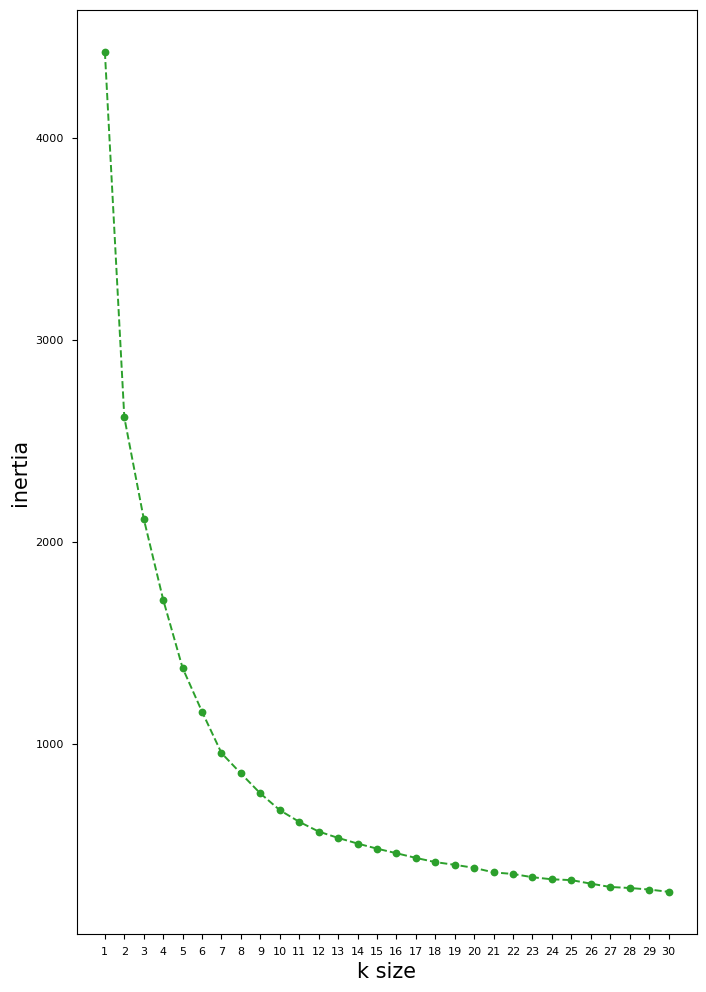

In [51]:
# 그래프로 출력
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

plt.clf()
plt.style.use('default')
plt.style.use('seaborn-paper')

xpos = np.array(range(1,31))
fig = plt.figure(figsize=(8, 12))
plt.plot(xpos, inertia, marker='o', linestyle='--', color='#2ca02c')
plt.xlabel("k size", fontsize=15)
plt.xticks(xpos, xpos)
plt.ylabel("inertia", fontsize=15)
plt.show()

### Silhouette Score
: 값이 높으면 객체가 자체 클러스터와 잘 일치하고 인접 클러스터와 잘 일치하지 않음을 나타냄
- 참고: https://nicola-ml.tistory.com/66

In [52]:
from sklearn.metrics import silhouette_score
import seaborn as sns
def visualize_silhouette_layer(data, param_init='k-means++', param_n_init=10, param_max_iter=300):
    clusters_range = range(2,40)
    results = []

    for i in clusters_range:
        clusterer = km(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")
    return pivot_km

pivot_km = visualize_silhouette_layer(exploit_embedding_list)

<Figure size 640x440 with 0 Axes>

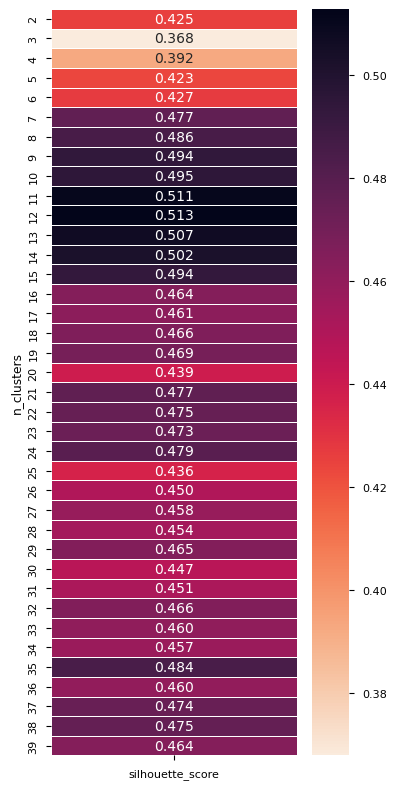

In [53]:
sns.reset_orig()
plt.clf()
fig = plt.figure(figsize=(4, 8))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()
plt.show()

분석 결과: 11~14 에서 가장 좋은 clustering이 발생

### K-mean Unsupervised learning

In [54]:
def unsupervised_learning(data, n): # n = k 수
    # cluster 개수 -> km_model.inertia_ 를 보면 기울기 변화가 적어지는 부분이 20
    km_model = km(n_clusters = n, algorithm = 'full', init='k-means++')
    km_model.fit(data)    # 학습
    predict_list = km_model.predict(data)    # clustering
    return predict_list

In [55]:
km_label = unsupervised_learning(exploit_embedding_list,12)
exploit['km_label'] = km_label
exploit

EID   PATH_NUM                                       SYSCALL_PATH  \
0     10613  exit_code                                           [102, 1]   
1     10613  exit_code                            [102, 1, 12, 12, 1, 59]   
2     10613  exit_code                                           [102, 1]   
3     10613  exit_code                            [102, 1, 12, 12, 1, 59]   
4     10613       main            [102, 104, 1, 117, 119, 9, 9, 9, 9, 11]   
...     ...        ...                                                ...   
4076   9545       main                                  [102, 104, 9, 41]   
4077   9545       main                  [102, 104, 9, 41, 87, 77, 40, 59]   
4078   9545       main                                      [102, 104, 9]   
4079   9575       main  [41, 9, 46, 46, 3, 13, 13, 14, 9, 14, 56, 11, ...   
4080   9575       main  [41, 9, 46, 46, 3, 13, 13, 14, 9, 14, 56, 11, ...   

      km_label  
0            9  
1            1  
2            9  
3            1  
4            1  
...        ...  
4076         1  
4077         1  
4078         1  
4079         6  
4080         6  

[3942 rows x 4 columns]

Text(0.5, 1.0, 'PCA Transformed')

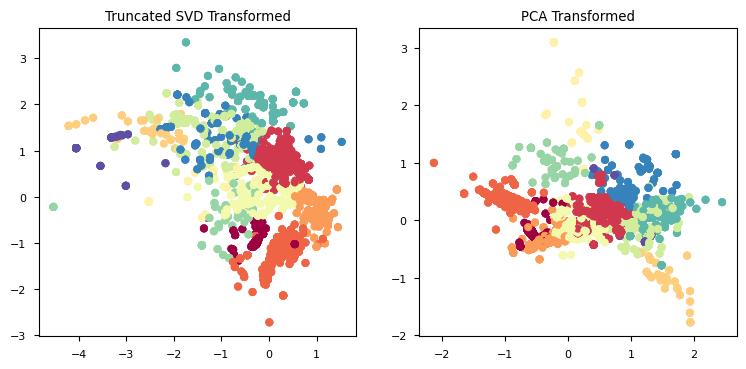

In [145]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD, PCA


# 특이값 분해
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(exploit_embedding_list)
scaler = StandardScaler() # exploit 데이터를 StandardScaler로 변환
exploit_tsvd = scaler.fit_transform(exploit_embedding_list)

# 스케일링된 데이터를 기반으로 PCA 변환 수행 
pca = PCA(n_components=0.95)
pca.fit(exploit_embedding_list)
exploit_pca = pca.transform(exploit_embedding_list)

# TruncatedSVD 변환 데이터를 왼쪽에, PCA변환 데이터를 오른쪽에 표현 
fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
ax1.scatter(x=exploit_tsvd[:,0], y= exploit_tsvd[:,1], c= exploit.km_label, cmap='Spectral')
ax2.scatter(x=exploit_pca[:,0], y= exploit_pca[:,1], c= exploit.km_label, cmap='Spectral')
ax1.set_title('Truncated SVD Transformed')
ax2.set_title('PCA Transformed')

In [138]:
pca = PCA(n_components=0.95)
components = pca.fit_transform(exploit_embedding_list)

total_var = pca.explained_variance_ratio_.sum() * 100
import plotly.express as px
fig = px.colors.qualitative.swatches()
fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=exploit.km_label,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    color_discrete_sequence=px.colors.qualitative.Dark24
)
fig.show(renderer="notebook")

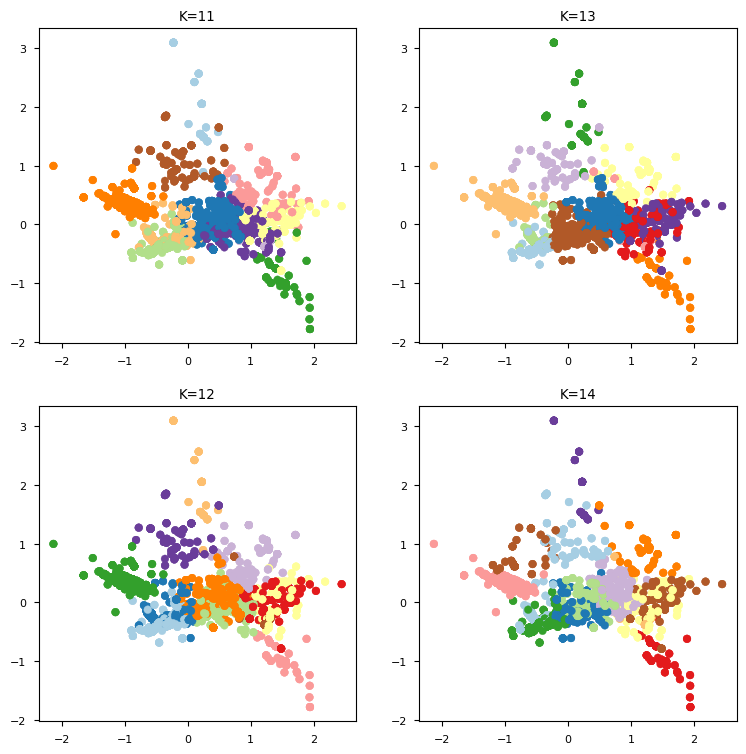

In [148]:
fig, ax = plt.subplots(figsize=(9,9),ncols=2, nrows=2)
j=0
plot_list = [11,12,13,14]
for i, k in enumerate(plot_list):
    km_label = unsupervised_learning(exploit_embedding_list,k)
    # TruncatedSVD 변환 데이터를 왼쪽에, PCA변환 데이터를 오른쪽에 표현 
    ax[i%2][j].scatter(x=exploit_pca[:,0], y= exploit_pca[:,1], c= km_label, cmap='Paired')
    ax[i%2][j].set_title(f'K={k}')
    if i == 1:
        j = 1

# 같은 그룹 끼리 Cosine 유사도 비교

In [70]:
k_label = len(set(exploit.km_label))
print("K-Mean++ label 수: ", len(set(exploit.km_label)))

K-Mean++ label 수:  12


In [71]:
same_cluster_exploit = set()
cluster_exploits = list()
for label in range(k_label):
    for idx in exploit[exploit['km_label'] == label].index:
        same_cluster_exploit.add(exploit.loc[idx].EID)
    cluster_exploits.append(same_cluster_exploit.copy())
    same_cluster_exploit = set()

In [72]:
# 익스플로잇 기준 속한 그룹
all_exploits = list(set(exploit['EID']))
for eid in all_exploits:
    print(eid, set(exploit[exploit['EID'] == eid]['km_label'].values)-{0})

43029 {9, 3, 1, 6}
40839 {3, 5, 6, 7}
8572 {1, 6}
33321 {1, 9}
33824 {1, 10, 3, 7}
33523 {7}
37722 {10, 3}
24746 {8, 2, 6}
2031 {6, 7}
895 {1, 3, 6, 7, 10}
40003 {10, 3}
33516 {9, 3, 6}
9083 {1, 2, 3, 6, 7, 8, 9, 10}
44302 {1, 3, 6, 7}
4756 {10, 6, 7}
37167 {1, 3}
2013 {6, 7}
25450 {1, 6, 7}
9542 {1}
5093 {9, 3, 1}
27297 {1}
2005 {9, 7}
26131 {9, 10, 6, 1}
2004 {6, 7}
8673 {4, 7}
15774 {1, 3}
37292 {6, 7}
31574 {1}
17391 {1, 2, 3, 6, 7, 8, 10}
9545 {1}
24555 {1}
14814 {1, 3}
35370 {2, 3, 6, 7, 8, 10}
25444 {1, 6}
50541 {1, 2, 4, 6, 7, 9}
45553 {1, 2, 3, 6, 7, 8, 10}
12 {3, 4, 7}
718 {9, 6}
38390 {9, 10, 7}
15944 {1, 6}
1397 {3, 5, 6, 9, 10}
50135 {2, 5, 8, 9, 10}
41886 {8}
31347 {1, 10, 6, 7}
41994 {1, 2, 3, 5, 6, 7, 8, 9, 10}
41995 {9}
43418 {1, 2, 3, 6, 8, 9}
20721 {4, 7}
42887 {10, 3, 6, 7}
4460 {6, 7}
15916 {3, 6}
32751 {9}
40871 {1, 2, 4, 6, 7, 8, 9}
6851 {1, 3, 6}
47163 {1, 2, 4, 6, 7, 9}
44303 {9, 3, 6}
20000 {1, 3}
34923 {9, 3, 7}
20720 {4, 7}
45010 {9, 11}
47168 {1, 2, 3, 5, 6

In [38]:
# def get_features(words, model, num_features):
#     # 출력 벡터 초기화
#     feature_vector = np.zeros((num_features), dtype=np.float32)
    
#     num_words = 0
#     # 어휘 사전 준비
#     index2word_set = set(model.wv.index2word)
    
#     for w in words:
#         if w in index2word_set:
#             num_words = 1
#             # 사전에 해당하는 단어에 대해 단어 벡터를 더함
#             feature_vector = np.add(feature_vector, model[w])
            
#     # 문장의 단어 수만큼 나누어 단어 벡터의 평균값을 문장 벡터로 함
#     feature_vector = np.divide(feature_vector, num_words)
#     return feature_vector
# get_features(all_dictionary, km_model, 4)
type(km_model)

AttributeError: 'KMeans' object has no attribute 'feature_names_in_ndarray'

In [27]:
# 클러스터 간의 핵심 단어 추출
def get_cluster_details(cluster_model, cluster_data, feature_names,
                       cluster_num, top_n_features=10):
    cluster_details = {}
    # 각 클러스터 레이블별 feature들의 center값들 내림차순으로 정렬 후의 인덱스를 반환
    center_feature_idx = cluster_model.cluster_centers_.argsort()[:,::-1]
    
    # 개별 클러스터 레이블별로 
    for cluster_num in range(cluster_num):
        # 개별 클러스터별 정보를 담을 empty dict할당
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num
        
        # 각 feature별 center값들 정렬한 인덱스 중 상위 10개만 추출
        top_ftr_idx = center_feature_idx[cluster_num, :top_n_features]
        top_ftr = [feature_names[idx] for idx in top_ftr_idx]
        # top_ftr_idx를 활용해서 상위 10개 feature들의 center값들 반환
        # 반환하게 되면 array이기 떄문에 리스트로바꾸기
        top_ftr_val = cluster_model.cluster_centers_[cluster_num, top_ftr_idx].tolist()
        
        # cluster_details 딕셔너리에다가 개별 군집 정보 넣어주기
        cluster_details[cluster_num]['top_features'] = top_ftr
        cluster_details[cluster_num]['top_featrues_value'] = top_ftr_val
        # 해당 cluster_num으로 분류된 파일명(문서들) 넣어주기
        filenames = cluster_data[cluster_data['label']==cluster_num]['EID']
        # filenames가 df으로 반환되기 떄문에 값들만 출력해서 array->list로 변환
        filenames = filenames.values.tolist()
        cluster_details[cluster_num]['EID'] = filenames
    
    return cluster_details

def print_cluster_details(cluster_details):
    for cluster_num, cluster_detail in cluster_details.items():
        print(f"#####Cluster Num: {cluster_num}")
        print()
        print("상위 10개 feature단어들:\n", cluster_detail['top_features'])
        print()
        print(f"Cluster {cluster_num}으로 분류된 문서들:\n{cluster_detail['EID'][:5]}")
        print('-'*20)

cluster_details = get_cluster_details(cluster_model=km_model,
                                     cluster_data=exploit_embedding_list,
                                     feature_names=all,
                                     cluster_num=k_label,
                                     top_n_features=10)
print_cluster_details(cluster_details)

TypeError: 'builtin_function_or_method' object is not subscriptable

In [114]:
# 그룹 기준 속한 익스플로잇 
all_exploits = list(set(exploit['EID']))
cluster_exploits = list()
for label in range(k_label):
    cluster_exploits.append(list(set(exploit[exploit['km_label'] == label]['EID'])))
for i, cluster in enumerate(cluster_exploits):
    print(f"<{i} cluster>", cluster)

<0 cluster> ['43345', '33336', '44302', '40871', '31347', '41995', '47170', '35370', '24746', '34923', '43418', '45553', '47169', '40616', '47168', '15916']
<1 cluster> ['35161', '43029', '40871', '8572', '33322', '41458', '40616', '17391', '6851', '33321', '47163', '9545', '24555', '20000', '14814', '33824', '25444', '50541', '15774', '45553', '895', '47168', '40049', '9083', '44302', '39230', '50808', '18411', '15944', '33589', '37167', '47170', '9479', '39277', '25450', '10613', '9542', '5093', '25288', '5092', '31347', '41994', '926', '25289', '27297', '43418', '26131', '44300', '47169', '15024', '31574']
<2 cluster> ['40871', '3', '44299', '41458', '17391', '47163', '35370', '24746', '50541', '45553', '47168', '40049', '9083', '18411', '47170', '50135', '33336', '41994', '15285', '43418', '44300', '47169']
<3 cluster> ['43029', '40839', '17391', '17787', '6851', '44303', '20000', '14814', '20979', '33824', '37722', '35370', '34923', '45553', '12', '895', '47168', '40003', '15023',

In [74]:
# EID: Syscall Path 형태로 만들어주기 (기존의 Syscall_Path 모두 붇이기)
exploit_only_one_path = pd.DataFrame( columns = {'EID','SYSCALL_PATH'})
new_data = {"EID":"", "SYSCALL_PATH": list()}
concat_path = list()
for idx in df.index:
    if idx == 0:
        new_data = {"EID":df.loc[idx,'EID'], "SYSCALL_PATH": df.loc[idx,'SYSCALL_PATH']}
    if not df.loc[idx,'EID'] == new_data["EID"]:
        exploit_only_one_path = exploit_only_one_path.append(new_data, ignore_index=True)
        new_data = {"EID":df.loc[idx,'EID'], "SYSCALL_PATH": df.loc[idx,'SYSCALL_PATH']}
        new_data["EID"] = df.loc[idx,'EID']
        new_data["SYSCALL_PATH"].extend(df.loc[idx,'SYSCALL_PATH'])
    else:
        new_data["SYSCALL_PATH"].extend(df.loc[idx,'SYSCALL_PATH'])
exploit_only_one_path

EID                                       SYSCALL_PATH
0    10613  [102, 1, 102, 1, 102, 1, 12, 12, 1, 59, 102, 1...
1       12  [101, 101, 101, 101, 101, 101, 101, 101, 101, ...
2     1397  [125, 125, 125, 125, 125, 125, 125, 125, 125, ...
3    14814  [12, 12, 257, 12, 12, 257, 5, 0, 5, 0, 5, 0, 3...
4    15023  [12, 12, 257, 12, 12, 257, 5, 0, 5, 0, 5, 0, 3...
..     ...                                                ...
96    9083  [3, 3, 3, 3, 3, 3, 3, 3, 3, 203, 203, 12, 12, ...
97     926  [13, 13, 14, 9, 14, 56, 11, 14, 61, 13, 13, 14...
98    9479  [102, 104, 135, 10, 257, 41, 40, 3, 41, 102, 4...
99    9542  [102, 104, 135, 9, 41, 44, 44, 102, 102, 104, ...
100   9545  [102, 104, 9, 41, 87, 77, 102, 104, 9, 41, 87,...

[101 rows x 2 columns]

In [75]:
# 각 exploit에 존재하는 system call들의 vector 값의 평균을 구하여 해당 exploit code의 vector값을 구함
def get_exploit_vectors(document_list):
    document_embedding_list = []

    # 각 Exploit에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line:
            if word in word2vec_model.wv.vocab:
                count += 1
                # 해당 Exploit에 있는 모든 syscall들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # syscall 벡터를 모두 더한 벡터의 값을 Exploit 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 Exploit에 대한 Exploit 벡터 리스트를 리턴
    return document_embedding_list

exploit_only_one_path_embedding_list = get_exploit_vectors(exploit_only_one_path['SYSCALL_PATH'])
print('문서 벡터의 수 :',len(exploit_only_one_path_embedding_list))

/tmp/ipykernel_2448756/167459078.py:14: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/tmp/ipykernel_2448756/167459078.py:16: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



문서 벡터의 수 : 101


In [76]:
from sklearn.metrics.pairwise import cosine_similarity
sim_df = list()
exploit_cosine_similarities = list()
sim_exploit_list = list()
xyticklabels = list()
for i, exploits in enumerate(cluster_exploits):
    for eid in exploits:
        if len(exploit_only_one_path[exploit_only_one_path['EID']==eid].index) > 0:
            idx = exploit_only_one_path[exploit_only_one_path['EID']==eid].index[0]
            sim_df.append(exploit_only_one_path_embedding_list[idx])
            sim_exploit_list.append(exploit_only_one_path.loc[idx].EID)
        
    exploit_cosine_similarities.append( cosine_similarity( sim_df, sim_df))
    print(f'Label {i} 코사인 유사도 매트릭스의 크기 :',exploit_cosine_similarities[i].shape)
    sim_df = []
    xyticklabels.append(sim_exploit_list.copy())
    sim_exploit_list = []

Label 0 코사인 유사도 매트릭스의 크기 : (16, 16)
Label 1 코사인 유사도 매트릭스의 크기 : (51, 51)
Label 2 코사인 유사도 매트릭스의 크기 : (22, 22)
Label 3 코사인 유사도 매트릭스의 크기 : (40, 40)
Label 4 코사인 유사도 매트릭스의 크기 : (13, 13)
Label 5 코사인 유사도 매트릭스의 크기 : (8, 8)
Label 6 코사인 유사도 매트릭스의 크기 : (60, 60)
Label 7 코사인 유사도 매트릭스의 크기 : (48, 48)
Label 8 코사인 유사도 매트릭스의 크기 : (17, 17)
Label 9 코사인 유사도 매트릭스의 크기 : (30, 30)
Label 10 코사인 유사도 매트릭스의 크기 : (29, 29)
Label 11 코사인 유사도 매트릭스의 크기 : (2, 2)


<Figure size 640x440 with 0 Axes>

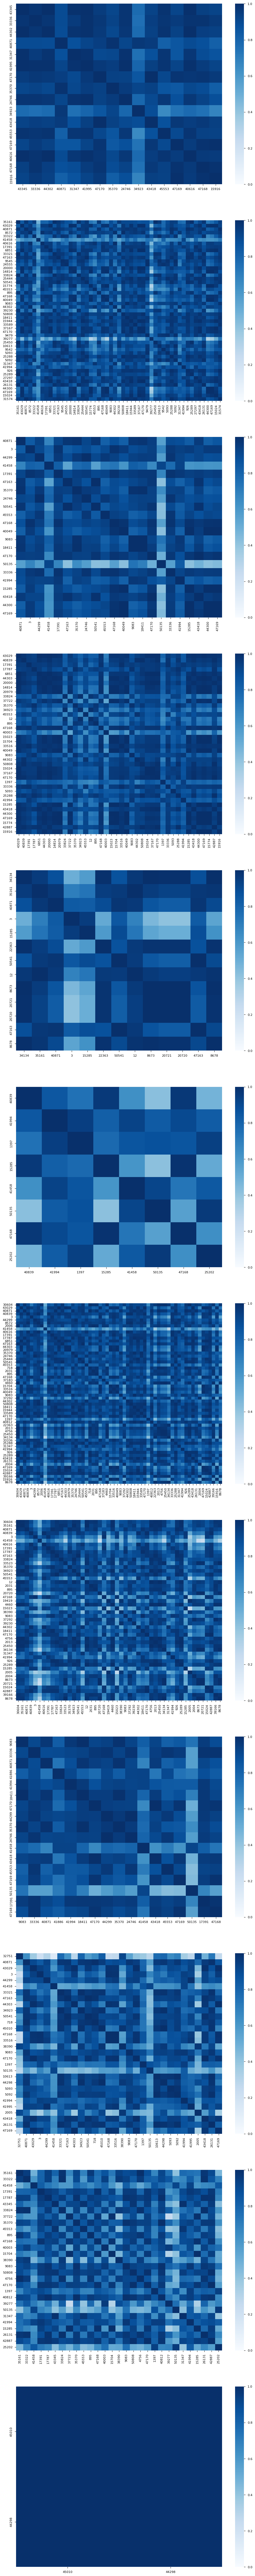

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.reset_orig()
plt.clf()
figure, ax = plt.subplots(nrows = k_label, ncols =1 )
figure.set_size_inches(k_label,k_label*10)


for i in range(k_label):
    sns.heatmap(exploit_cosine_similarities[i], xticklabels= xyticklabels[i], yticklabels= xyticklabels[i], cmap='Blues', vmin=0, vmax=1, annot=False, ax = ax[i])


### 익스플로잇의 Cluster Similiarity 구하기

In [152]:
def jaccard_sim(A, B):
    print("sum",len(A|B))
    print("inter", len(A&B))
    return len(A&B)/len(A|B)

In [79]:
exploit

EID   PATH_NUM                                       SYSCALL_PATH  \
0     10613  exit_code  [102, 1, 102, 1, 102, 1, 12, 12, 1, 59, 102, 1...   
1     10613  exit_code                            [102, 1, 12, 12, 1, 59]   
2     10613  exit_code                                           [102, 1]   
3     10613  exit_code                            [102, 1, 12, 12, 1, 59]   
4     10613       main            [102, 104, 1, 117, 119, 9, 9, 9, 9, 11]   
...     ...        ...                                                ...   
4076   9545       main                                  [102, 104, 9, 41]   
4077   9545       main                  [102, 104, 9, 41, 87, 77, 40, 59]   
4078   9545       main                                      [102, 104, 9]   
4079   9575       main  [41, 9, 46, 46, 3, 13, 13, 14, 9, 14, 56, 11, ...   
4080   9575       main  [41, 9, 46, 46, 3, 13, 13, 14, 9, 14, 56, 11, ...   

      km_label  
0            9  
1            1  
2            9  
3            1  
4            1  
...        ...  
4076         1  
4077         1  
4078         1  
4079         6  
4080         6  

[3942 rows x 4 columns]

In [88]:
exploit_cluster_dict = dict()
for idx in exploit.index:
    if not exploit['EID'][idx] in exploit_cluster_dict:
        exploit_cluster_dict[exploit['EID'][idx]] = set()
    exploit_cluster_dict[exploit['EID'][idx]].add(exploit['km_label'][idx])
exploit_cluster_dict

{'10613': {1, 9},
 '12': {3, 4, 7},
 '1397': {3, 5, 6, 9, 10},
 '14814': {1, 3},
 '15023': {3, 7},
 '15024': {1, 3, 6, 7},
 '15285': {2, 3, 4, 5, 7, 10},
 '15704': {3, 6, 10},
 '15774': {1, 3},
 '15916': {0, 3, 6},
 '15944': {1, 6},
 '17391': {1, 2, 3, 6, 7, 8, 10},
 '17787': {3, 6, 7, 10},
 '18411': {1, 2, 6, 7, 8},
 '19419': {7},
 '20000': {1, 3},
 '2004': {6, 7},
 '2005': {7, 9},
 '2006': {6},
 '2013': {6, 7},
 '2031': {6, 7},
 '20720': {4, 7},
 '20721': {4, 7},
 '20979': {3, 6},
 '22363': {4, 6},
 '24555': {1},
 '24746': {0, 2, 6, 8},
 '25202': {5, 10},
 '25288': {1, 3, 6},
 '25289': {1, 6, 7},
 '25444': {1, 6},
 '25450': {1, 6, 7},
 '26131': {1, 6, 9, 10},
 '27297': {1},
 '3': {2, 4, 6, 7, 9},
 '30604': {6, 7},
 '31347': {0, 1, 6, 7, 10},
 '31574': {1},
 '32751': {9},
 '33321': {1, 9},
 '33322': {1, 10},
 '33336': {0, 2, 3, 6, 8},
 '33516': {3, 6, 9},
 '33523': {7},
 '33589': {1, 6},
 '33824': {1, 3, 7, 10},
 '34134': {4, 6, 7},
 '34923': {0, 3, 7, 9},
 '35161': {1, 4, 7, 10},
 '3

In [100]:
cluster_similarity_list = list()
for i, clusterA in enumerate(exploit_cluster_dict.values()):
    one_similarity = []
    for j, clusterB in enumerate(exploit_cluster_dict.values()):
        one_similarity.append(jaccard_sim(clusterA, clusterB))
    cluster_similarity_list.append(one_similarity)

cluster_similarity = pd.DataFrame(cluster_similarity_list, index=exploit_cluster_dict.keys(), columns=exploit_cluster_dict.keys())
cluster_similarity

10613        12      1397     14814     15023     15024     15285  \
10613  1.000000  0.000000  0.166667  0.333333  0.000000  0.200000  0.000000   
12     0.000000  1.000000  0.142857  0.250000  0.666667  0.400000  0.500000   
1397   0.166667  0.142857  1.000000  0.166667  0.166667  0.285714  0.375000   
14814  0.333333  0.250000  0.166667  1.000000  0.333333  0.500000  0.142857   
15023  0.000000  0.666667  0.166667  0.333333  1.000000  0.500000  0.333333   
...         ...       ...       ...       ...       ...       ...       ...   
926    0.250000  0.200000  0.142857  0.250000  0.250000  0.750000  0.125000   
9479   0.500000  0.000000  0.000000  0.500000  0.000000  0.250000  0.000000   
9542   0.500000  0.000000  0.000000  0.500000  0.000000  0.250000  0.000000   
9545   0.500000  0.000000  0.000000  0.500000  0.000000  0.250000  0.000000   
9575   0.000000  0.000000  0.200000  0.000000  0.000000  0.250000  0.000000   

          15704     15774     15916  ...      8572      8673      8678  \
10613  0.000000  0.333333  0.000000  ...  0.333333  0.000000  0.000000   
12     0.200000  0.250000  0.200000  ...  0.000000  0.666667  0.500000   
1397   0.600000  0.166667  0.333333  ...  0.166667  0.000000  0.142857   
14814  0.250000  1.000000  0.250000  ...  0.333333  0.000000  0.000000   
15023  0.250000  0.333333  0.250000  ...  0.000000  0.333333  0.250000   
...         ...       ...       ...  ...       ...       ...       ...   
926    0.200000  0.250000  0.200000  ...  0.666667  0.250000  0.500000   
9479   0.000000  0.500000  0.000000  ...  0.500000  0.000000  0.000000   
9542   0.000000  0.500000  0.000000  ...  0.500000  0.000000  0.000000   
9545   0.000000  0.500000  0.000000  ...  0.500000  0.000000  0.000000   
9575   0.333333  0.000000  0.333333  ...  0.500000  0.000000  0.333333   

            895      9083       926      9479      9542      9545      9575  
10613  0.166667  0.250000  0.250000  0.500000  0.500000  0.500000  0.000000  
12     0.333333  0.222222  0.200000  0.000000  0.000000  0.000000  0.000000  
1397   0.428571  0.444444  0.142857  0.000000  0.000000  0.000000  0.200000  
14814  0.400000  0.250000  0.250000  0.500000  0.500000  0.500000  0.000000  
15023  0.400000  0.250000  0.250000  0.000000  0.000000  0.000000  0.000000  
...         ...       ...       ...       ...       ...       ...       ...  
926    0.600000  0.375000  1.000000  0.333333  0.333333  0.333333  0.333333  
9479   0.200000  0.125000  0.333333  1.000000  1.000000  1.000000  0.000000  
9542   0.200000  0.125000  0.333333  1.000000  1.000000  1.000000  0.000000  
9545   0.200000  0.125000  0.333333  1.000000  1.000000  1.000000  0.000000  
9575   0.200000  0.125000  0.333333  0.000000  0.000000  0.000000  1.000000  

[102 rows x 102 columns]

<AxesSubplot:>

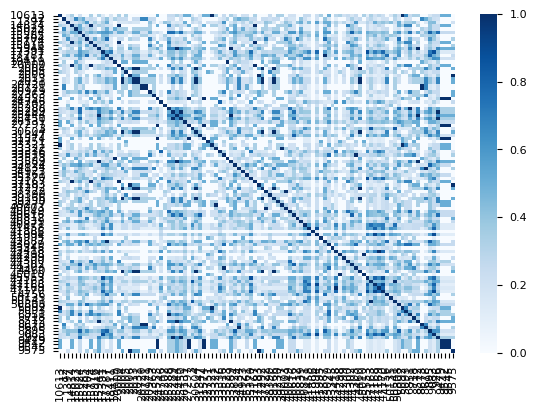

In [98]:
sns.reset_orig()
plt.clf()
sns.heatmap(cluster_similarity, xticklabels= exploit_cluster_dict.keys(), yticklabels= exploit_cluster_dict.keys(), cmap='Blues', vmin=0, vmax=1, annot=False)

In [112]:
for EID in exploit_cluster_dict.keys():
    for i, top_index in enumerate(cluster_similarity.sort_values(EID, ascending=False).index):
        if EID == top_index:
            continue
        if i == 10:
            break
        print(EID, ",", top_index,",",cluster_similarity[top_index][EID])

10613 , 33321 , 1.0
10613 , 5092 , 1.0
10613 , 5093 , 0.6666666666666666
10613 , 32751 , 0.5
10613 , 31574 , 0.5
10613 , 27297 , 0.5
10613 , 26131 , 0.5
10613 , 24555 , 0.5
10613 , 43029 , 0.5
12 , 20720 , 0.6666666666666666
12 , 20721 , 0.6666666666666666
12 , 15023 , 0.6666666666666666
12 , 8673 , 0.6666666666666666
12 , 15285 , 0.5
12 , 34134 , 0.5
12 , 8678 , 0.5
12 , 40839 , 0.4
12 , 17787 , 0.4
1397 , 44303 , 0.6
1397 , 15704 , 0.6
1397 , 33516 , 0.6
1397 , 41994 , 0.5555555555555556
1397 , 26131 , 0.5
1397 , 17787 , 0.5
1397 , 40839 , 0.5
1397 , 50808 , 0.5
1397 , 43029 , 0.5
14814 , 37167 , 1.0
14814 , 15774 , 1.0
14814 , 20000 , 1.0
14814 , 44300 , 0.6666666666666666
14814 , 5093 , 0.6666666666666666
14814 , 25288 , 0.6666666666666666
14814 , 6851 , 0.6666666666666666
14814 , 9542 , 0.5
14814 , 43029 , 0.5
15023 , 12 , 0.6666666666666666
15023 , 42887 , 0.5
15023 , 40839 , 0.5
15023 , 19419 , 0.5
15023 , 17787 , 0.5
15023 , 33523 , 0.5
15023 , 15024 , 0.5
15023 , 34923 , 0.5
1

34923 , 15916 , 0.4
34923 , 44303 , 0.4
35161 , 33824 , 0.6
35161 , 39277 , 0.5
35161 , 8673 , 0.5
35161 , 31347 , 0.5
35161 , 895 , 0.5
35161 , 20721 , 0.5
35161 , 20720 , 0.5
35161 , 39230 , 0.5
35161 , 33322 , 0.5
35370 , 45553 , 0.875
35370 , 47170 , 0.7777777777777778
35370 , 17391 , 0.75
35370 , 33336 , 0.7142857142857143
35370 , 47168 , 0.7
35370 , 9083 , 0.6666666666666666
35370 , 41994 , 0.6
35370 , 24746 , 0.5714285714285714
35370 , 42887 , 0.5714285714285714
37167 , 14814 , 1.0
37167 , 15774 , 1.0
37167 , 20000 , 1.0
37167 , 44300 , 0.6666666666666666
37167 , 5093 , 0.6666666666666666
37167 , 25288 , 0.6666666666666666
37167 , 6851 , 0.6666666666666666
37167 , 9542 , 0.5
37167 , 43029 , 0.5
37183 , 2006 , 1.0
37183 , 9575 , 1.0
37183 , 37292 , 0.5
37183 , 33589 , 0.5
37183 , 20979 , 0.5
37183 , 2031 , 0.5
37183 , 2013 , 0.5
37183 , 25444 , 0.5
37183 , 2004 , 0.5
37292 , 39166 , 1.0
37292 , 2013 , 1.0
37292 , 2004 , 1.0
37292 , 30604 , 1.0
37292 , 2031 , 1.0
37292 , 4460 , 1.

8678 , 2031 , 0.6666666666666666
8678 , 2013 , 0.6666666666666666
895 , 42887 , 0.8
895 , 33824 , 0.8
895 , 50808 , 0.8
895 , 15024 , 0.8
895 , 17787 , 0.8
895 , 17391 , 0.7142857142857143
895 , 44302 , 0.6666666666666666
895 , 31347 , 0.6666666666666666
895 , 45553 , 0.625
9083 , 47170 , 0.8888888888888888
9083 , 41994 , 0.8888888888888888
9083 , 17391 , 0.875
9083 , 47168 , 0.8
9083 , 41458 , 0.7777777777777778
9083 , 45553 , 0.7777777777777778
9083 , 43418 , 0.6666666666666666
9083 , 35370 , 0.6666666666666666
9083 , 47169 , 0.6666666666666666
926 , 25450 , 1.0
926 , 25289 , 1.0
926 , 40616 , 0.75
926 , 15024 , 0.75
926 , 8572 , 0.6666666666666666
926 , 30604 , 0.6666666666666666
926 , 25444 , 0.6666666666666666
926 , 4460 , 0.6666666666666666
926 , 39230 , 0.6666666666666666
9479 , 31574 , 1.0
9479 , 9545 , 1.0
9479 , 9542 , 1.0
9479 , 24555 , 1.0
9479 , 27297 , 1.0
9479 , 10613 , 0.5
9479 , 33322 , 0.5
9479 , 33321 , 0.5
9479 , 8572 , 0.5
9542 , 31574 , 1.0
9542 , 9545 , 1.0
9542 

In [158]:
jaccard_sim(exploit_cluster_dict['47168'],exploit_cluster_dict['41994'])
print(exploit_cluster_dict['47168'])
print(exploit_cluster_dict['41994'])
print(set(km_label))

sum 10
inter 9
{0, 1, 2, 3, 5, 6, 7, 8, 9, 10}
{1, 2, 3, 5, 6, 7, 8, 9, 10}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}
